In [1]:
import os
import math
import sys
import warnings

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torchvision import transforms as T
from torchmetrics.detection.map import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor

from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings("ignore")

### Classes

In [40]:
anno_file = np.genfromtxt('data/GTSDB/gt.txt',delimiter =';', dtype= None,encoding=None)

anno_dict = {}

for img_id, xmin, ymin, xmax, ymax, label in anno_file:
    if img_id in anno_dict:
        anno_dict[img_id]["boxes"] += [[xmin, ymin, xmax, ymax]]
        anno_dict[img_id]["labels"] += [label]
    else:
        anno_dict[img_id] = {}
        anno_dict[img_id]["boxes"] = [[xmin, ymin, xmax, ymax]]
        anno_dict[img_id]["labels"] = [label]

print(f"images: {len(anno_dict)}")
print(f"signs: {len(anno_file)}")

images: 741
signs: 1213


In [41]:
anno_dict["00001.ppm"]

{'boxes': [[983, 388, 1024, 432], [386, 494, 442, 552], [973, 335, 1031, 390]],
 'labels': [40, 38, 13]}

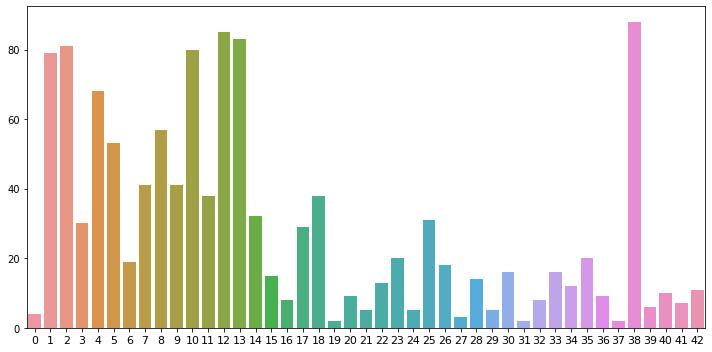

In [42]:
count_labels = {i: 0 for i in range(0,43)}
for _, target in anno_dict.items():
    for label in target['labels']:
        count_labels[label] += 1

fig = plt.figure(figsize=(10,5))
x, y = list(zip(*count_labels.items()))
sns.barplot(x=list(x), y=list(y))
plt.tight_layout()
plt.show()

### Dataset

In [43]:
class GTSDB(torch.utils.data.Dataset):
    def __init__(self, image_dir, transforms=None, only_detect=False):
        self.image_dir = image_dir
        self.transforms = transforms
        self.only_detect = only_detect
        self.imgs = list(sorted(os.listdir(image_dir)))
 
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target = anno_dict.get(self.imgs[idx]) 

        if target is not None:
            target["boxes"] = torch.as_tensor(target['boxes'], dtype=torch.float32)

            target["labels"] = (
                torch.as_tensor(target["labels"], dtype=torch.int64)
                if not self.only_detect
                else torch.ones(len(target["labels"]), dtype=torch.int64)
            )

        else:
            target = {}
            target["boxes"] = torch.empty((0,4), dtype=torch.float32)
            target["labels"] = torch.empty((0), dtype=torch.int64)
 
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [44]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Transforms

In [45]:
def get_transform(train):
    if train:
        return T.Compose(
            [
                T.ColorJitter(brightness=0.5, contrast=0.5),
                T.GaussianBlur(kernel_size=(3, 11), sigma=(0.1, 3)),
                T.ToTensor(),
            ]
        )
    else:
        return T.Compose([T.ToTensor()])

### Train

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [47]:
only_detect = True
num_classes = 2 if only_detect else 42

dataset_trian = GTSDB("data/GTSDB/train", transforms=get_transform(True), only_detect=only_detect)
dataset_val = GTSDB("data/GTSDB/test", transforms=get_transform(False), only_detect=only_detect)

data_loader_train = torch.utils.data.DataLoader(
    dataset_trian,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)
data_loader_test = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    )

In [10]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler=None, writer=None):
    model.train()

    total_loss = []

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for idx, (images, targets) in enumerate(
        tqdm(data_loader, desc=f"Epoch [{epoch+1}]", position=0, leave=True)
    ):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # loss
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        total_loss += [losses.item()]

    if writer is not None:
        writer.add_scalar("Loss/train", np.mean(total_loss), epoch)

    return np.mean(total_loss)

@torch.inference_mode()
def evaluate(model, data_loader, device, metric, writer=None):
    model.eval()

    for images, targets in tqdm(data_loader, desc="Evaluating score", position=0, leave=True):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.cuda.amp.autocast(enabled=False):
            detections = model(images, targets)

        metric.update(detections, targets)

    scores = metric.compute()
    metric.reset()


    model.train() # to get loss

    total_loss = []

    for images, targets in tqdm(data_loader, desc="Evaluating loss", position=0, leave=True):
        # to device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        total_loss += [losses.item()]

    if writer is not None:
        writer.add_scalar("Loss/val", np.mean(total_loss), epoch)
        writer.add_scalars("Score/val", scores, epoch)

    return np.mean(total_loss), scores


In [13]:

# backbone = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', True)
# backbone.out_channels = 256
# anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
# aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
# rpn_anchor_generator = AnchorGenerator(
#     anchor_sizes, aspect_ratios
# )
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=[0],
#     output_size=7,
#     sampling_ratio=2)
# model = FasterRCNN(
#     backbone, 
#     num_classes=num_classes,
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

# model = fasterrcnn_resnet50_fpn(
#     pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True
# )

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

val_metric = MeanAveragePrecision()

train_losses = []
val_losses = []
val_scores = []

writer = SummaryWriter(log_dir="logs/gtsdb/run_5")

model = model.to(device)

for epoch in range(num_epochs):
    # train one epoch
    loss = train_one_epoch(model, optimizer, data_loader_train, device=device, epoch=epoch, writer=writer)
    train_losses += [loss]

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    loss, scores = evaluate(model, data_loader_test, device=device, metric=val_metric, writer=writer)
    val_losses += [loss]
    val_scores += [scores]

writer.flush()


Evaluating loss: 100%|██████████| 150/150 [00:28<00:00,  5.26it/s]


#### Save model

In [14]:
torch.save(model, f'./saved_models/model{num_epochs}.pkl')
torch.save(model.state_dict(), f'./saved_models/model{num_epochs}.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, f'./saved_models/ckpt{num_epochs}.pth')

### Plot

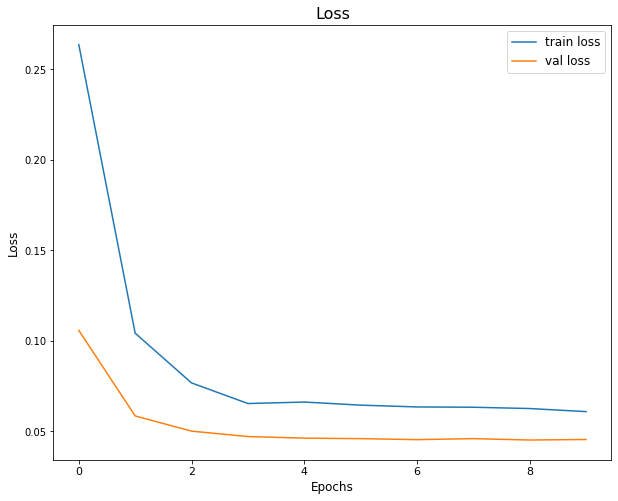

In [37]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10,8))
plt.plot(epochs, train_losses, label="train loss")
plt.plot(epochs, val_losses, label="val loss")
plt.xlabel("Epochs", fontdict={'size': 12})
plt.ylabel("Loss", fontdict={'size': 12})
plt.title("Loss", fontdict={'size': 16})
plt.legend(prop={'size': 12})
plt.show()

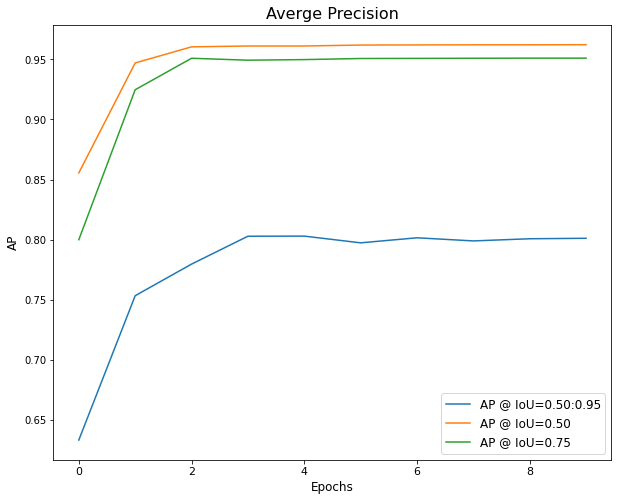

In [36]:
val_map = [elm['map'] for elm in val_scores]
val_map50 = [elm['map_50'] for elm in val_scores]
val_map75 = [elm['map_75'] for elm in val_scores]

score_metric = "AP" if only_detect else "mAP"

fig = plt.figure(figsize=(10,8))
plt.plot(epochs, val_map, label=f"{score_metric} @ IoU=0.50:0.95")
plt.plot(epochs, val_map50, label=f"{score_metric} @ IoU=0.50")
plt.plot(epochs, val_map75, label=f"{score_metric} @ IoU=0.75")
plt.xlabel("Epochs", fontdict={'size': 12})
plt.ylabel(score_metric, fontdict={'size': 12})
plt.title("Averge Precision", fontdict={'size': 16})
plt.legend(prop={'size': 12})
plt.show()

In [28]:
final_score = val_scores[-1]
final_score

{'map': 0.8011,
 'map_50': 0.9622,
 'map_75': 0.951,
 'map_small': 0.7079,
 'map_medium': 0.8211,
 'map_large': 0.8796,
 'mar_1': 0.549,
 'mar_10': 0.856,
 'mar_100': 0.856,
 'mar_small': 0.82,
 'mar_medium': 0.8726,
 'mar_large': 0.9,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0}

In [38]:
model = torch.load("saved_models/model10.pkl")

In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

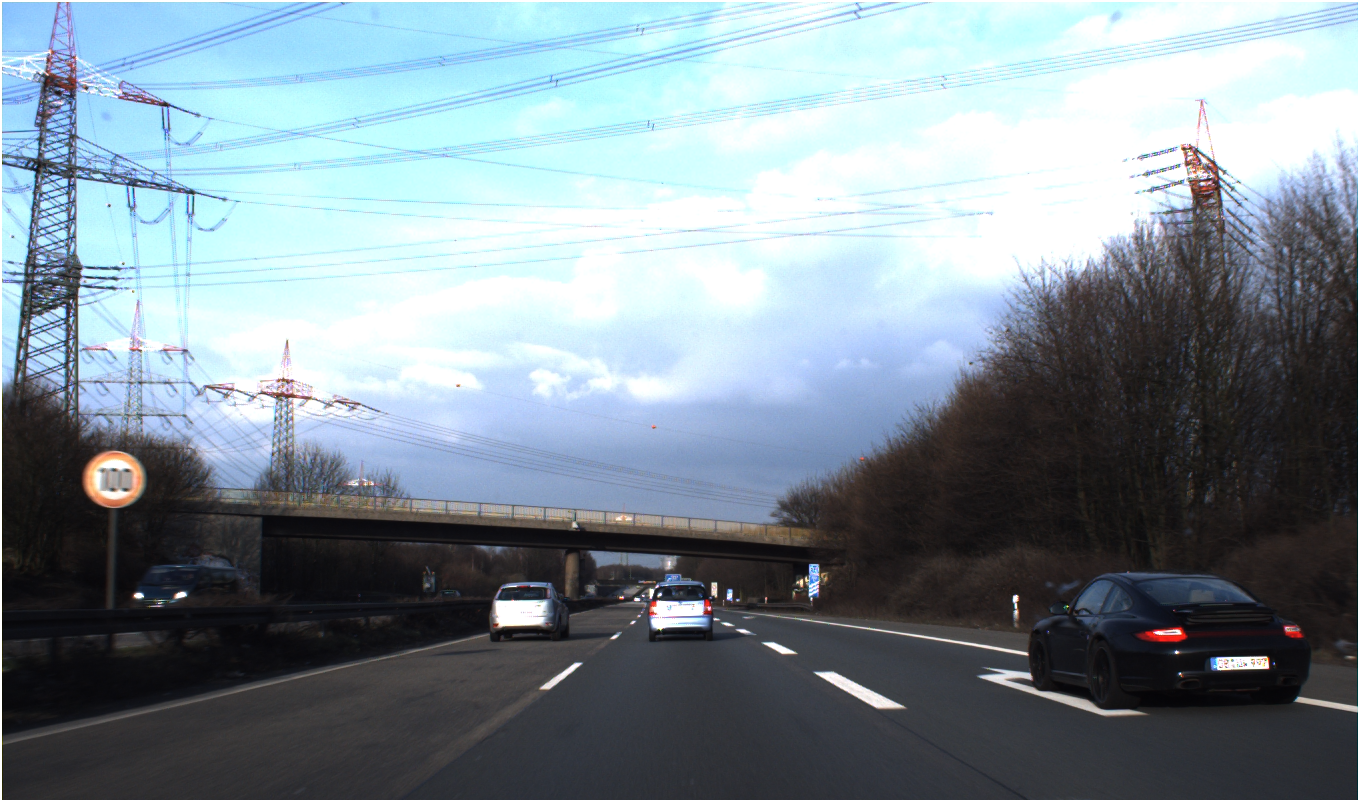

In [54]:
T.ToPILImage()(dataset_val[1][0])



In [55]:
dataset_val[1][1]

{'boxes': tensor([[ 82., 450., 145., 508.]]), 'labels': tensor([1])}